# Wordle Solver Bot

##### by Vincent Rettke

### THIS IS A NEW VERSION OF THE SAME BOT. Old bot is not compatible with wordle's new HTML changes.

### use OLD CODE for Wordle Unlimited.

Using Selenium, I will create a program that plays Wordle better than my girlfriend, girlfriend's mom, my mom, and myself.

After doing some research online, it appears there are many complex algorithms for solving the Wordle puzzle, including the ACTUAL future solutions up to year 2028 :(

However, my bot will have no knowledge of the future and will be created using my own Wordle logic (more fun this way)!

Things to consider:
- choose good first word
- not historic solution
- avoid duplicate letters (unless words with non-duplicates are very uncommon)
- account for green/yellow letters
- use list of possible wordle solutions
- prioritize popular letters

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
import time
import random
import string
import numpy as np
import pandas as pd

##### FUNCTIONS:

In [29]:
# access url
def open_page(url):
    browser = webdriver.Chrome()
    browser.get(url)
    time.sleep(3)
    return browser

# close light box instructions
def close_light_box():
    game_app = browser.find_element(By.CSS_SELECTOR, '#wordle-app-game > div.Modal-module_modalOverlay__81ZCi > div > div > svg')
    game_app.click()
    time.sleep(1)

# try first word
def get_first_word():
    for guess in first_guesses:
        if guess in future_solutions:
            actions.send_keys(guess)
            break
    # guess = 'adieu'     # choose adieu or trace
    actions.send_keys(guess)
    actions.perform()
    time.sleep(1)
    actions.send_keys(Keys.RETURN)
    actions.perform()
    time.sleep(3)
    return guess
    
# access tile elements
def get_tiles(rowNum):
    rows = browser.find_elements(By.CLASS_NAME, value='Row-module_row__dEHfN')
    tiles = rows[rowNum].find_elements(By.CLASS_NAME, value='Tile-module_tile__3ayIZ')
    return tiles

# returns conditions for next guess
def get_word_cond(rowNum, conditions, lastTry, nextWordFlag):
    
    tiles = get_tiles(rowNum)
    
    letters = []
    for tile in tiles:
        letters.append(tile.text.lower())
    print(letters)
        
    evaluations = []
    for tile in tiles:
        evaluations.append(tile.get_attribute('data-state'))
        
    if nextWordFlag == True:
        conditions.append(f"and word != {lastTry}")
        nextWordFlag = False
        
    for x in range(5):
        if evaluations[x] == 'correct':
            if letters[x] in wrong_letters:   # remove condition that says letter is not in word
                wrong_letters.remove(letters[x])
                while f"'{letters[x]}' not in word" in conditions:
                    conditions.remove(f"'{letters[x]}' not in word")
                while f"and '{letters[x]}' not in word" in conditions:
                    conditions.remove(f"and '{letters[x]}' not in word")
            if x not in correct_tiles:
                correct_tiles.append(x)
                if x in wrong_tiles:
                    wrong_tiles.remove(x)
            correct_letters.append(letters[x])
            if x == 0 and rowNum == 0:
                conditions.append(f"word[{x}]=='{letters[x]}'")
            else:
                conditions.append(f"and word[{x}]=='{letters[x]}'")
        elif evaluations[x] == 'present':
            if letters[x] in wrong_letters:   # remove condition that says letter is not in word
                wrong_letters.remove(letters[x])
                while f"'{letters[x]}' not in word" in conditions:
                    conditions.remove(f"'{letters[x]}' not in word")
                while f"and '{letters[x]}' not in word" in conditions:
                    conditions.remove(f"and '{letters[x]}' not in word")
            if x not in wrong_tiles:
                wrong_tiles.append(x)
            correct_letters.append(letters[x])
            if x == 0 and rowNum == 0:
                conditions.append(f"'{letters[x]}' in word and word[{x}]!='{letters[x]}'")
            else:
                conditions.append(f"and '{letters[x]}' in word and word[{x}]!='{letters[x]}'") 
        elif evaluations[x] == 'absent' and letters[x] in correct_letters: # what if it becomes incorrect later in word?
            if x not in wrong_tiles:
                wrong_tiles.append(x)
            for y in range(5):   # cond accounts for letter already guessed in correct tile (e.g. green in spot 1, grey in spot 2) 
                if y in wrong_tiles:
                    if x == 0 and rowNum == 0:
                        conditions.append(f"word[{y}]!='{letters[x]}'")
                    else:
                        conditions.append(f"and word[{y}]!='{letters[x]}'")
        else:
            wrong_letters.append(letters[x]) # new
            if x not in wrong_tiles:   
                wrong_tiles.append(x)
            if x == 0 and rowNum == 0:
                conditions.append(f"'{letters[x]}' not in word")
            else:
                conditions.append(f"and '{letters[x]}' not in word")
        condition = ' '.join(conditions)      
    print(condition)
    return condition
    
# choose a new word to guess
def generate_guess(rowNum, conditions, lastTry, nextWordFlag):
    valid_word_cond = get_word_cond(rowNum, conditions, lastTry, nextWordFlag)   # get word condition
    
    for word in future_solutions:
        if word is not None:
            word = list(word)
        
            if eval(valid_word_cond):
                word = ''.join(word)
                return word, nextWordFlag
     
    return 'loser', nextWordFlag
    
# types a guess
def type_word(word):
    actions.send_keys(word)
    actions.perform()
    time.sleep(1)
    actions.send_keys(Keys.RETURN)
    actions.perform()
    time.sleep(3)
    
def clear_word():
    for x in range(5):
        actions.send_keys(Keys.BACKSPACE)
        actions.perform()
    time.sleep(1)
    
# sorts list of future solutions by vowel count (prioritize more vowels)
def sort_by_vowels(future_solutions):
    new_list = []
    list_length = len(future_solutions)
    temp = 'xxx'
    vCount = 0
    while(len(new_list) < list_length):
        for word in future_solutions:
            count = 0
            if word is not None:
                unique_letters = set(list(word))
                for letter in unique_letters:
                    if letter in 'aeiourtlsn':
                        count+=1
                if count > vCount:
                    vCount = count
                    temp = word
        try:
            future_solutions.remove(temp)
        except:
            print(f'Cannot remove {temp}')
        new_list.append(temp)
        vCount = 0
    return new_list

# starts a new game
# def play_again():
#     # get through shadow roots to access play again button (helpful shadow DOM link below)
#     firstHost = browser.find_element(By.TAG_NAME, value="game-app")
#     root1 = getShadowRoot(firstHost)
#     secondHost = root1.find_element(By.CSS_SELECTOR, value="#game > game-modal > game-stats")     # host is <game-stats>
#     root2 = getShadowRoot(secondHost)
    
#     newGameButton = root2.find_element(By.ID, value='refresh-button')     # found new game button
#     newGameButton.click()
    
# get robots game stats
# def get_stats(sum_score, avg_score):
#     sum_score += game_score
#     avg_score = sum_score/game_num
#     return sum_score, avg_score

Create a list of best first guesses for quick solves.
Using source: https://www.inverse.com/culture/wordle-top-3-start-words

In [30]:
# list of first guesses
first_guesses = ['slice', 'tried', 'crane', 'leant', 'close', 'trice', 'train', 'slate', 'lance', 'trace']

# all possible wordle solutions
all_solutions = ["cigar","rebut","sissy","humph","awake","blush","focal","evade","naval","serve","heath","dwarf","model","karma","stink","grade","quiet","bench","abate","feign","major","death","fresh","crust","stool","colon","abase","marry","react","batty","pride","floss","helix","croak","staff","paper","unfed","whelp","trawl","outdo","adobe","crazy","sower","repay","digit","crate","cluck","spike","mimic","pound","maxim","linen","unmet","flesh","booby","forth","first","stand","belly","ivory","seedy","print","yearn","drain","bribe","stout","panel","crass","flume","offal","agree","error","swirl","argue","bleed","delta","flick","totem","wooer","front","shrub","parry","biome","lapel","start","greet","goner","golem","lusty","loopy","round","audit","lying","gamma","labor","islet","civic","forge","corny","moult","basic","salad","agate","spicy","spray","essay","fjord","spend","kebab","guild","aback","motor","alone","hatch","hyper","thumb","dowry","ought","belch","dutch","pilot","tweed","comet","jaunt","enema","steed","abyss","growl","fling","dozen","boozy","erode","world","gouge","click","briar","great","altar","pulpy","blurt","coast","duchy","groin","fixer","group","rogue","badly","smart","pithy","gaudy","chill","heron","vodka","finer","surer","radio","rouge","perch","retch","wrote","clock","tilde","store","prove","bring","solve","cheat","grime","exult","usher","epoch","triad","break","rhino","viral","conic","masse","sonic","vital","trace","using","peach","champ","baton","brake","pluck","craze","gripe","weary","picky","acute","ferry","aside","tapir","troll","unify","rebus","boost","truss","siege","tiger","banal","slump","crank","gorge","query","drink","favor","abbey","tangy","panic","solar","shire","proxy","point","robot","prick","wince","crimp","knoll","sugar","whack","mount","perky","could","wrung","light","those","moist","shard","pleat","aloft","skill","elder","frame","humor","pause","ulcer","ultra","robin","cynic","agora","aroma","caulk","shake","pupal","dodge","swill","tacit","other","thorn","trove","bloke","vivid","spill","chant","choke","rupee","nasty","mourn","ahead","brine","cloth","hoard","sweet","month","lapse","watch","today","focus","smelt","tease","cater","movie","lynch","saute","allow","renew","their","slosh","purge","chest","depot","epoxy","nymph","found","shall","harry","stove","lowly","snout","trope","fewer","shawl","natal","fibre","comma","foray","scare","stair","black","squad","royal","chunk","mince","slave","shame","cheek","ample","flair","foyer","cargo","oxide","plant","olive","inert","askew","heist","shown","zesty","hasty","trash","fella","larva","forgo","story","hairy","train","homer","badge","midst","canny","fetus","butch","farce","slung","tipsy","metal","yield","delve","being","scour","glass","gamer","scrap","money","hinge","album","vouch","asset","tiara","crept","bayou","atoll","manor","creak","showy","phase","froth","depth","gloom","flood","trait","girth","piety","payer","goose","float","donor","atone","primo","apron","blown","cacao","loser","input","gloat","awful","brink","smite","beady","rusty","retro","droll","gawky","hutch","pinto","gaily","egret","lilac","sever","field","fluff","hydro","flack","agape","wench","voice","stead","stalk","berth","madam","night","bland","liver","wedge","augur","roomy","wacky","flock","angry","bobby","trite","aphid","tryst","midge","power","elope","cinch","motto","stomp","upset","bluff","cramp","quart","coyly","youth","rhyme","buggy","alien","smear","unfit","patty","cling","glean","label","hunky","khaki","poker","gruel","twice","twang","shrug","treat","unlit","waste","merit","woven","octal","needy","clown","widow","irony","ruder","gauze","chief","onset","prize","fungi","charm","gully","inter","whoop","taunt","leery","class","theme","lofty","tibia","booze","alpha","thyme","eclat","doubt","parer","chute","stick","trice","alike","sooth","recap","saint","liege","glory","grate","admit","brisk","soggy","usurp","scald","scorn","leave","twine","sting","bough","marsh","sloth","dandy","vigor","howdy","enjoy","valid","ionic","equal","unset","floor","catch","spade","stein","exist","quirk","denim","grove","spiel","mummy","fault","foggy","flout","carry","sneak","libel","waltz","aptly","piney","inept","aloud","photo","dream","stale","vomit","ombre","fanny","unite","snarl","baker","there","glyph","pooch","hippy","spell","folly","louse","gulch","vault","godly","threw","fleet","grave","inane","shock","crave","spite","valve","skimp","claim","rainy","musty","pique","daddy","quasi","arise","aging","valet","opium","avert","stuck","recut","mulch","genre","plume","rifle","count","incur","total","wrest","mocha","deter","study","lover","safer","rivet","funny","smoke","mound","undue","sedan","pagan","swine","guile","gusty","equip","tough","canoe","chaos","covet","human","udder","lunch","blast","stray","manga","melee","lefty","quick","paste","given","octet","risen","groan","leaky","grind","carve","loose","sadly","spilt","apple","slack","honey","final","sheen","eerie","minty","slick","derby","wharf","spelt","coach","erupt","singe","price","spawn","fairy","jiffy","filmy","stack","chose","sleep","ardor","nanny","niece","woozy","handy","grace","ditto","stank","cream","usual","diode","valor","angle","ninja","muddy","chase","reply","prone","spoil","heart","shade","diner","arson","onion","sleet","dowel","couch","palsy","bowel","smile","evoke","creek","lance","eagle","idiot","siren","built","embed","award","dross","annul","goody","frown","patio","laden","humid","elite","lymph","edify","might","reset","visit","gusto","purse","vapor","crock","write","sunny","loath","chaff","slide","queer","venom","stamp","sorry","still","acorn","aping","pushy","tamer","hater","mania","awoke","brawn","swift","exile","birch","lucky","freer","risky","ghost","plier","lunar","winch","snare","nurse","house","borax","nicer","lurch","exalt","about","savvy","toxin","tunic","pried","inlay","chump","lanky","cress","eater","elude","cycle","kitty","boule","moron","tenet","place","lobby","plush","vigil","index","blink","clung","qualm","croup","clink","juicy","stage","decay","nerve","flier","shaft","crook","clean","china","ridge","vowel","gnome","snuck","icing","spiny","rigor","snail","flown","rabid","prose","thank","poppy","budge","fiber","moldy","dowdy","kneel","track","caddy","quell","dumpy","paler","swore","rebar","scuba","splat","flyer","horny","mason","doing","ozone","amply","molar","ovary","beset","queue","cliff","magic","truce","sport","fritz","edict","twirl","verse","llama","eaten","range","whisk","hovel","rehab","macaw","sigma","spout","verve","sushi","dying","fetid","brain","buddy","thump","scion","candy","chord","basin","march","crowd","arbor","gayly","musky","stain","dally","bless","bravo","stung","title","ruler","kiosk","blond","ennui","layer","fluid","tatty","score","cutie","zebra","barge","matey","bluer","aider","shook","river","privy","betel","frisk","bongo","begun","azure","weave","genie","sound","glove","braid","scope","wryly","rover","assay","ocean","bloom","irate","later","woken","silky","wreck","dwelt","slate","smack","solid","amaze","hazel","wrist","jolly","globe","flint","rouse","civil","vista","relax","cover","alive","beech","jetty","bliss","vocal","often","dolly","eight","joker","since","event","ensue","shunt","diver","poser","worst","sweep","alley","creed","anime","leafy","bosom","dunce","stare","pudgy","waive","choir","stood","spoke","outgo","delay","bilge","ideal","clasp","seize","hotly","laugh","sieve","block","meant","grape","noose","hardy","shied","drawl","daisy","putty","strut","burnt","tulip","crick","idyll","vixen","furor","geeky","cough","naive","shoal","stork","bathe","aunty","check","prime","brass","outer","furry","razor","elect","evict","imply","demur","quota","haven","cavil","swear","crump","dough","gavel","wagon","salon","nudge","harem","pitch","sworn","pupil","excel","stony","cabin","unzip","queen","trout","polyp","earth","storm","until","taper","enter","child","adopt","minor","fatty","husky","brave","filet","slime","glint","tread","steal","regal","guest","every","murky","share","spore","hoist","buxom","inner","otter","dimly","level","sumac","donut","stilt","arena","sheet","scrub","fancy","slimy","pearl","silly","porch","dingo","sepia","amble","shady","bread","friar","reign","dairy","quill","cross","brood","tuber","shear","posit","blank","villa","shank","piggy","freak","which","among","fecal","shell","would","algae","large","rabbi","agony","amuse","bushy","copse","swoon","knife","pouch","ascot","plane","crown","urban","snide","relay","abide","viola","rajah","straw","dilly","crash","amass","third","trick","tutor","woody","blurb","grief","disco","where","sassy","beach","sauna","comic","clued","creep","caste","graze","snuff","frock","gonad","drunk","prong","lurid","steel","halve","buyer","vinyl","utile","smell","adage","worry","tasty","local","trade","finch","ashen","modal","gaunt","clove","enact","adorn","roast","speck","sheik","missy","grunt","snoop","party","touch","mafia","emcee","array","south","vapid","jelly","skulk","angst","tubal","lower","crest","sweat","cyber","adore","tardy","swami","notch","groom","roach","hitch","young","align","ready","frond","strap","puree","realm","venue","swarm","offer","seven","dryer","diary","dryly","drank","acrid","heady","theta","junto","pixie","quoth","bonus","shalt","penne","amend","datum","build","piano","shelf","lodge","suing","rearm","coral","ramen","worth","psalm","infer","overt","mayor","ovoid","glide","usage","poise","randy","chuck","prank","fishy","tooth","ether","drove","idler","swath","stint","while","begat","apply","slang","tarot","radar","credo","aware","canon","shift","timer","bylaw","serum","three","steak","iliac","shirk","blunt","puppy","penal","joist","bunny","shape","beget","wheel","adept","stunt","stole","topaz","chore","fluke","afoot","bloat","bully","dense","caper","sneer","boxer","jumbo","lunge","space","avail","short","slurp","loyal","flirt","pizza","conch","tempo","droop","plate","bible","plunk","afoul","savoy","steep","agile","stake", "dwell","knave","beard","arose","motif","smash","broil","glare","shove","baggy","mammy","swamp","along","rugby","wager","quack","squat","snaky","debit","mange","skate","ninth","joust","tramp","spurn","medal","micro","rebel","flank","learn","nadir","maple","comfy","remit","gruff","ester","least","mogul","fetch","cause","oaken","aglow","meaty","gaffe","shyly","racer","prowl","thief","stern","poesy","rocky","tweet","waist","spire","grope","havoc","patsy","truly","forty","deity","uncle","swish","giver","preen","bevel","lemur","draft","slope","annoy","lingo","bleak","ditty","curly","cedar","dirge","grown","horde","drool","shuck","crypt","cumin","stock","gravy","locus","wider","breed","quite","chafe","cache","blimp","deign","fiend","logic","cheap","elide","rigid","false","renal","pence","rowdy","shoot","blaze","envoy","posse","brief","never","abort","mouse","mucky","sulky","fiery","media","trunk","yeast","clear","skunk","scalp","bitty","cider","koala","duvet","segue","creme","super","grill","after","owner","ember","reach","nobly","empty","speed","gipsy","recur","smock","dread","merge","burst","kappa","amity","shaky","hover","carol","snort","synod","faint","haunt","flour","chair","detox","shrew","tense","plied","quark","burly","novel","waxen","stoic","jerky","blitz","beefy","lyric","hussy","towel","quilt","below","bingo","wispy","brash","scone","toast","easel","saucy","value","spice","honor","route","sharp","bawdy","radii","skull","phony","issue","lager","swell","urine","gassy","trial","flora","upper","latch","wight","brick","retry","holly","decal","grass","shack","dogma","mover","defer","sober","optic","crier","vying","nomad","flute","hippo","shark","drier","obese","bugle","tawny","chalk","feast","ruddy","pedal","scarf","cruel","bleat","tidal","slush","semen","windy","dusty","sally","igloo","nerdy","jewel","shone","whale","hymen","abuse","fugue","elbow","crumb","pansy","welsh","syrup","terse","suave","gamut","swung","drake","freed","afire","shirt","grout","oddly","tithe","plaid","dummy","broom","blind","torch","enemy","again","tying","pesky","alter","gazer","noble","ethos","bride","extol","decor","hobby","beast","idiom","utter","these","sixth","alarm","erase","elegy","spunk","piper","scaly","scold","hefty","chick","sooty","canal","whiny","slash","quake","joint","swept","prude","heavy","wield","femme","lasso","maize","shale","screw","spree","smoky","whiff","scent","glade","spent","prism","stoke","riper","orbit","cocoa","guilt","humus","shush","table","smirk","wrong","noisy","alert","shiny","elate","resin","whole","hunch","pixel","polar","hotel","sword","cleat","mango","rumba","puffy","filly","billy","leash","clout","dance","ovate","facet","chili","paint","liner","curio","salty","audio","snake","fable","cloak","navel","spurt","pesto","balmy","flash","unwed","early","churn","weedy","stump","lease","witty","wimpy","spoof","saner","blend","salsa","thick","warty","manic","blare","squib","spoon","probe","crepe","knack","force","debut","order","haste","teeth","agent","widen","icily","slice","ingot","clash","juror","blood","abode","throw","unity","pivot","slept","troop","spare","sewer","parse","morph","cacti","tacky","spool","demon","moody","annex","begin","fuzzy","patch","water","lumpy","admin","omega","limit","tabby","macho","aisle","skiff","basis","plank","verge","botch","crawl","lousy","slain","cubic","raise","wrack","guide","foist","cameo","under","actor","revue","fraud","harpy","scoop","climb","refer","olden","clerk","debar","tally","ethic","cairn","tulle","ghoul","hilly","crude","apart","scale","older","plain","sperm","briny","abbot","rerun","quest","crisp","bound","befit","drawn","suite","itchy","cheer","bagel","guess","broad","axiom","chard","caput","leant","harsh","curse","proud","swing","opine","taste","lupus","gumbo","miner","green","chasm","lipid","topic","armor","brush","crane","mural","abled","habit","bossy","maker","dusky","dizzy","lithe","brook","jazzy","fifty","sense","giant","surly","legal","fatal","flunk","began","prune","small","slant","scoff","torus","ninny","covey","viper","taken","moral","vogue","owing","token","entry","booth","voter","chide","elfin","ebony","neigh","minim","melon","kneed","decoy","voila","ankle","arrow","mushy","tribe","cease","eager","birth","graph","odder","terra","weird","tried","clack","color","rough","weigh","uncut","ladle","strip","craft","minus","dicey","titan","lucid","vicar","dress","ditch","gypsy","pasta","taffy","flame","swoop","aloof","sight","broke","teary","chart","sixty","wordy","sheer","leper","nosey","bulge","savor","clamp","funky","foamy","toxic","brand","plumb","dingy","butte","drill","tripe","bicep","tenor","krill","worse","drama","hyena","think","ratio","cobra","basil","scrum","bused","phone","court","camel","proof","heard","angel","petal","pouty","throb","maybe","fetal","sprig","spine","shout","cadet","macro","dodgy","satyr","rarer","binge","trend","nutty","leapt","amiss","split","myrrh","width","sonar","tower","baron","fever","waver","spark","belie","sloop","expel","smote","baler","above","north","wafer","scant","frill","awash","snack","scowl","frail","drift","limbo","fence","motel","ounce","wreak","revel","talon","prior","knelt","cello","flake","debug","anode","crime","salve","scout","imbue","pinky","stave","vague","chock","fight","video","stone","teach","cleft","frost","prawn","booty","twist","apnea","stiff","plaza","ledge","tweak","board","grant","medic","bacon","cable","brawl","slunk","raspy","forum","drone","women","mucus","boast","toddy","coven","tumor","truer","wrath","stall","steam","axial","purer","daily","trail","niche","mealy","juice","nylon","plump","merry","flail","papal","wheat","berry","cower","erect","brute","leggy","snipe","sinew","skier","penny","jumpy","rally","umbra","scary","modem","gross","avian","greed","satin","tonic","parka","sniff","livid","stark","trump","giddy","reuse","taboo","avoid","quote","devil","liken","gloss","gayer","beret","noise","gland","dealt","sling","rumor","opera","thigh","tonga","flare","wound","white","bulky","etude","horse","circa","paddy","inbox","fizzy","grain","exert","surge","gleam","belle","salvo","crush","fruit","sappy","taker","tract","ovine","spiky","frank","reedy","filth","spasm","heave","mambo","right","clank","trust","lumen","borne","spook","sauce","amber","lathe","carat","corer","dirty","slyly","affix","alloy","taint","sheep","kinky","wooly","mauve","flung","yacht","fried","quail","brunt","grimy","curvy","cagey","rinse","deuce","state","grasp","milky","bison","graft","sandy","baste","flask","hedge","girly","swash","boney","coupe","endow","abhor","welch","blade","tight","geese","miser","mirth","cloud","cabal","leech","close","tenth","pecan","droit","grail","clone","guise","ralph","tango","biddy","smith","mower","payee","serif","drape","fifth","spank","glaze","allot","truck","kayak","virus","testy","tepee","fully","zonal","metro","curry","grand","banjo","axion","bezel","occur","chain","nasal","gooey","filer","brace","allay","pubic","raven","plead","gnash","flaky","munch","dully","eking","thing","slink","hurry","theft","shorn","pygmy","ranch","wring","lemon","shore","mamma","froze","newer","style","moose","antic","drown","vegan","chess","guppy","union","lever","lorry","image","cabby","druid","exact","truth","dopey","spear","cried","chime","crony","stunk","timid","batch","gauge","rotor","crack","curve","latte","witch","bunch","repel","anvil","soapy","meter","broth","madly","dried","scene","known","magma","roost","woman","thong","punch","pasty","downy","knead","whirl","rapid","clang","anger","drive","goofy","email","music","stuff","bleep","rider","mecca","folio","setup","verso","quash","fauna","gummy","happy","newly","fussy","relic","guava","ratty","fudge","femur","chirp","forte","alibi","whine","petty","golly","plait","fleck","felon","gourd","brown","thrum","ficus","stash","decry","wiser","junta","visor","daunt","scree","impel","await","press","whose","turbo","stoop","speak","mangy","eying","inlet","crone","pulse","mossy","staid","hence","pinch","teddy","sully","snore","ripen","snowy","attic","going","leach","mouth","hound","clump","tonal","bigot","peril","piece","blame","haute","spied","undid","intro","basal","shine","gecko","rodeo","guard","steer","loamy","scamp","scram","manly","hello","vaunt","organ","feral","knock","extra","condo","adapt","willy","polka","rayon","skirt","faith","torso","match","mercy","tepid","sleek","riser","twixt","peace","flush","catty","login","eject","roger","rival","untie","refit","aorta","adult","judge","rower","artsy","rural","shave"]

# all past solution
old_solutions = ["gloom", "froth", "cigar","rebut","sissy","humph","awake","blush","focal","evade","naval","serve","heath","dwarf","model","karma","stink","grade","quiet","bench","abate","feign","major","death","fresh","crust","stool","colon","abase","marry","react","batty","pride","floss","helix","croak","staff","paper","unfed","whelp","trawl","outdo","adobe","crazy","sower","repay","digit","crate","cluck","spike","mimic","pound","maxim","linen","unmet","flesh","booby","forth","first","stand","belly","ivory","seedy","print","yearn","drain","bribe","stout","panel","crass","flume","offal","agree","error","swirl","argue","bleed","delta","flick","totem","wooer","front","shrub","parry","biome","lapel","start","greet","goner","golem","lusty","loopy","round","audit","lying","gamma","labor","islet","civic","forge","corny","moult","basic","salad","agate","spicy","spray","essay","fjord","spend","kebab","guild","aback","motor","alone","hatch","hyper","thumb","dowry","ought","belch","dutch","pilot","tweed","comet","jaunt","enema","steed","abyss","growl","fling","dozen","boozy","erode","world","gouge","click","briar","great","altar","pulpy","blurt","coast","duchy","groin","fixer","group","rogue","badly","smart","pithy","gaudy","chill","heron","vodka","finer","surer","radio","rouge","perch","retch","wrote","clock","tilde","store","prove","bring","solve","cheat","grime","exult","usher","epoch","triad","break","rhino","viral","conic","masse","sonic","vital","trace","using","peach","champ","baton","brake","pluck","craze","gripe","weary","picky","acute","ferry","aside","tapir","troll","unify","rebus","boost","truss","siege","tiger","banal","slump","crank","gorge","query","drink","favor","abbey","tangy","panic","solar","shire","proxy","point","robot","prick","wince","crimp","knoll","sugar","whack","mount","perky","could","wrung","light","those","moist","shard","pleat","aloft","skill","elder","frame","humor","pause","ulcer","ultra","robin","cynic","aroma","caulk","shake","dodge","swill","tacit","other","thorn","trove","bloke","vivid","spill","chant","choke","rupee","nasty","mourn","ahead","brine","cloth","hoard","sweet","month","lapse","watch","today","focus","smelt","tease","cater","movie","saute","allow","renew","their","slosh","purge","chest","depot","epoxy","nymph","found","shall","harry","stove","lowly","snout","trope","fewer","shawl","natal","comma","foray","scare","stair","black","squad","royal","chunk","mince","shame","cheek","ample","flair","foyer","cargo","oxide","plant","olive","inert","askew","heist","shown","zesty","hasty","trash","fella","larva","forgo","story","hairy","train","homer","badge","midst","canny","fetus","butch","farce","slung","tipsy","metal","yield","delve","being","scour","glass","gamer","scrap","money","hinge","album","vouch","asset","tiara","crept","bayou","atoll","manor","creak"]

# 5 letter words, not in future solutions list
more_words = pd.read_csv('sgb-words.csv')
more_words = [list(row)[0] for row in more_words.values]

# all future solutions in random order
future_solutions = []
for word in all_solutions:
    if word not in old_solutions:
        future_solutions.append(word)
random.shuffle(future_solutions)
future_solutions.append(random.shuffle(list(set(more_words))))    # add additional unique words to end of list

# # if unlimited: comment previous block, use this one
# future_solutions = all_solutions
# random.shuffle(future_solutions)
# future_solutions.append(random.shuffle(list(set(more_words))))

In [31]:
# prioritize future solutions by vowel count
future_solutions = sort_by_vowels(future_solutions)

Cannot remove chuck
Cannot remove chuck


##### WORDLE BOT'S SOLUTION:

In [33]:
daily = r'https://www.nytimes.com/games/wordle/index.html'     # daily wordle
browser = open_page(daily) 

# specify number of runs (keep this as 1. It is always daily)
runs = 1

# enable page actions for all functions
actions = ActionChains(browser)

# close initial light box
close_light_box()

# # initialize bot stats
# avg_score = 0
# sum_score = 0

game_num = 0   # always initialize at 0
while game_num < runs:
    
    # initially, there are no word conditions and a score of 0
    conditions = []
    game_score = 0

    # initialize lists for correct and wrong tile indices
    correct_tiles = []     # solved tiles
    correct_letters = []   # letters in the word
    wrong_tiles = []       # unsolved tiles
    wrong_letters = []     # letters NOT in the word (sometimes a letter in this list will be at the end of the word)


    nextWordFlag = False
    
    # first guess
    guess = get_first_word()

    counter = 0
    while counter < 6:
        if len(correct_tiles) == 5:     # close the browser
            game_score = counter
            counter = 100
            browser.quit()

        else:
            if nextWordFlag == False:
                guess, nextWordFlag = generate_guess(counter, conditions, guess, nextWordFlag)
                type_word(guess)

            else:
                clear_word()

            counter += 1
        if counter == 6:
            game_score = counter
            
    game_num += 1
    # sum_score, avg_score = get_stats(sum_score, avg_score)   # get robot's statistics
    # print(f'game {game_num}: {game_score}')
    
    # play_again()   # uncomment for unlimited
    # time.sleep(2)

# close the browser
browser.quit()

# print(f'Sum of Scores: {sum_score}')
# print(f'Avg of Scores: {avg_score}')

['s', 'l', 'i', 'c', 'e']
's' not in word and 'l' not in word and 'i' not in word and 'c' not in word and 'e' in word and word[4]!='e'
['t', 'e', 'n', 'o', 'r']
's' not in word and 'l' not in word and 'i' not in word and 'c' not in word and 'e' in word and word[4]!='e' and 't' in word and word[0]!='t' and word[1]=='e' and 'n' not in word and 'o' in word and word[3]!='o' and 'r' in word and word[4]!='r'
['m', 'e', 't', 'r', 'o']
's' not in word and 'l' not in word and 'i' not in word and 'c' not in word and 'e' in word and word[4]!='e' and 't' in word and word[0]!='t' and word[1]=='e' and 'n' not in word and 'o' in word and word[3]!='o' and 'r' in word and word[4]!='r' and 'm' not in word and word[1]=='e' and word[2]=='t' and word[3]=='r' and word[4]=='o'
['r', 'e', 't', 'r', 'o']
's' not in word and 'l' not in word and 'i' not in word and 'c' not in word and 'e' in word and word[4]!='e' and 't' in word and word[0]!='t' and word[1]=='e' and 'n' not in word and 'o' in word and word[3]!='

### Helpful Links:

Getting through Shadow DOM: https://cosmocode.io/how-to-interact-with-shadow-dom-in-selenium/ 

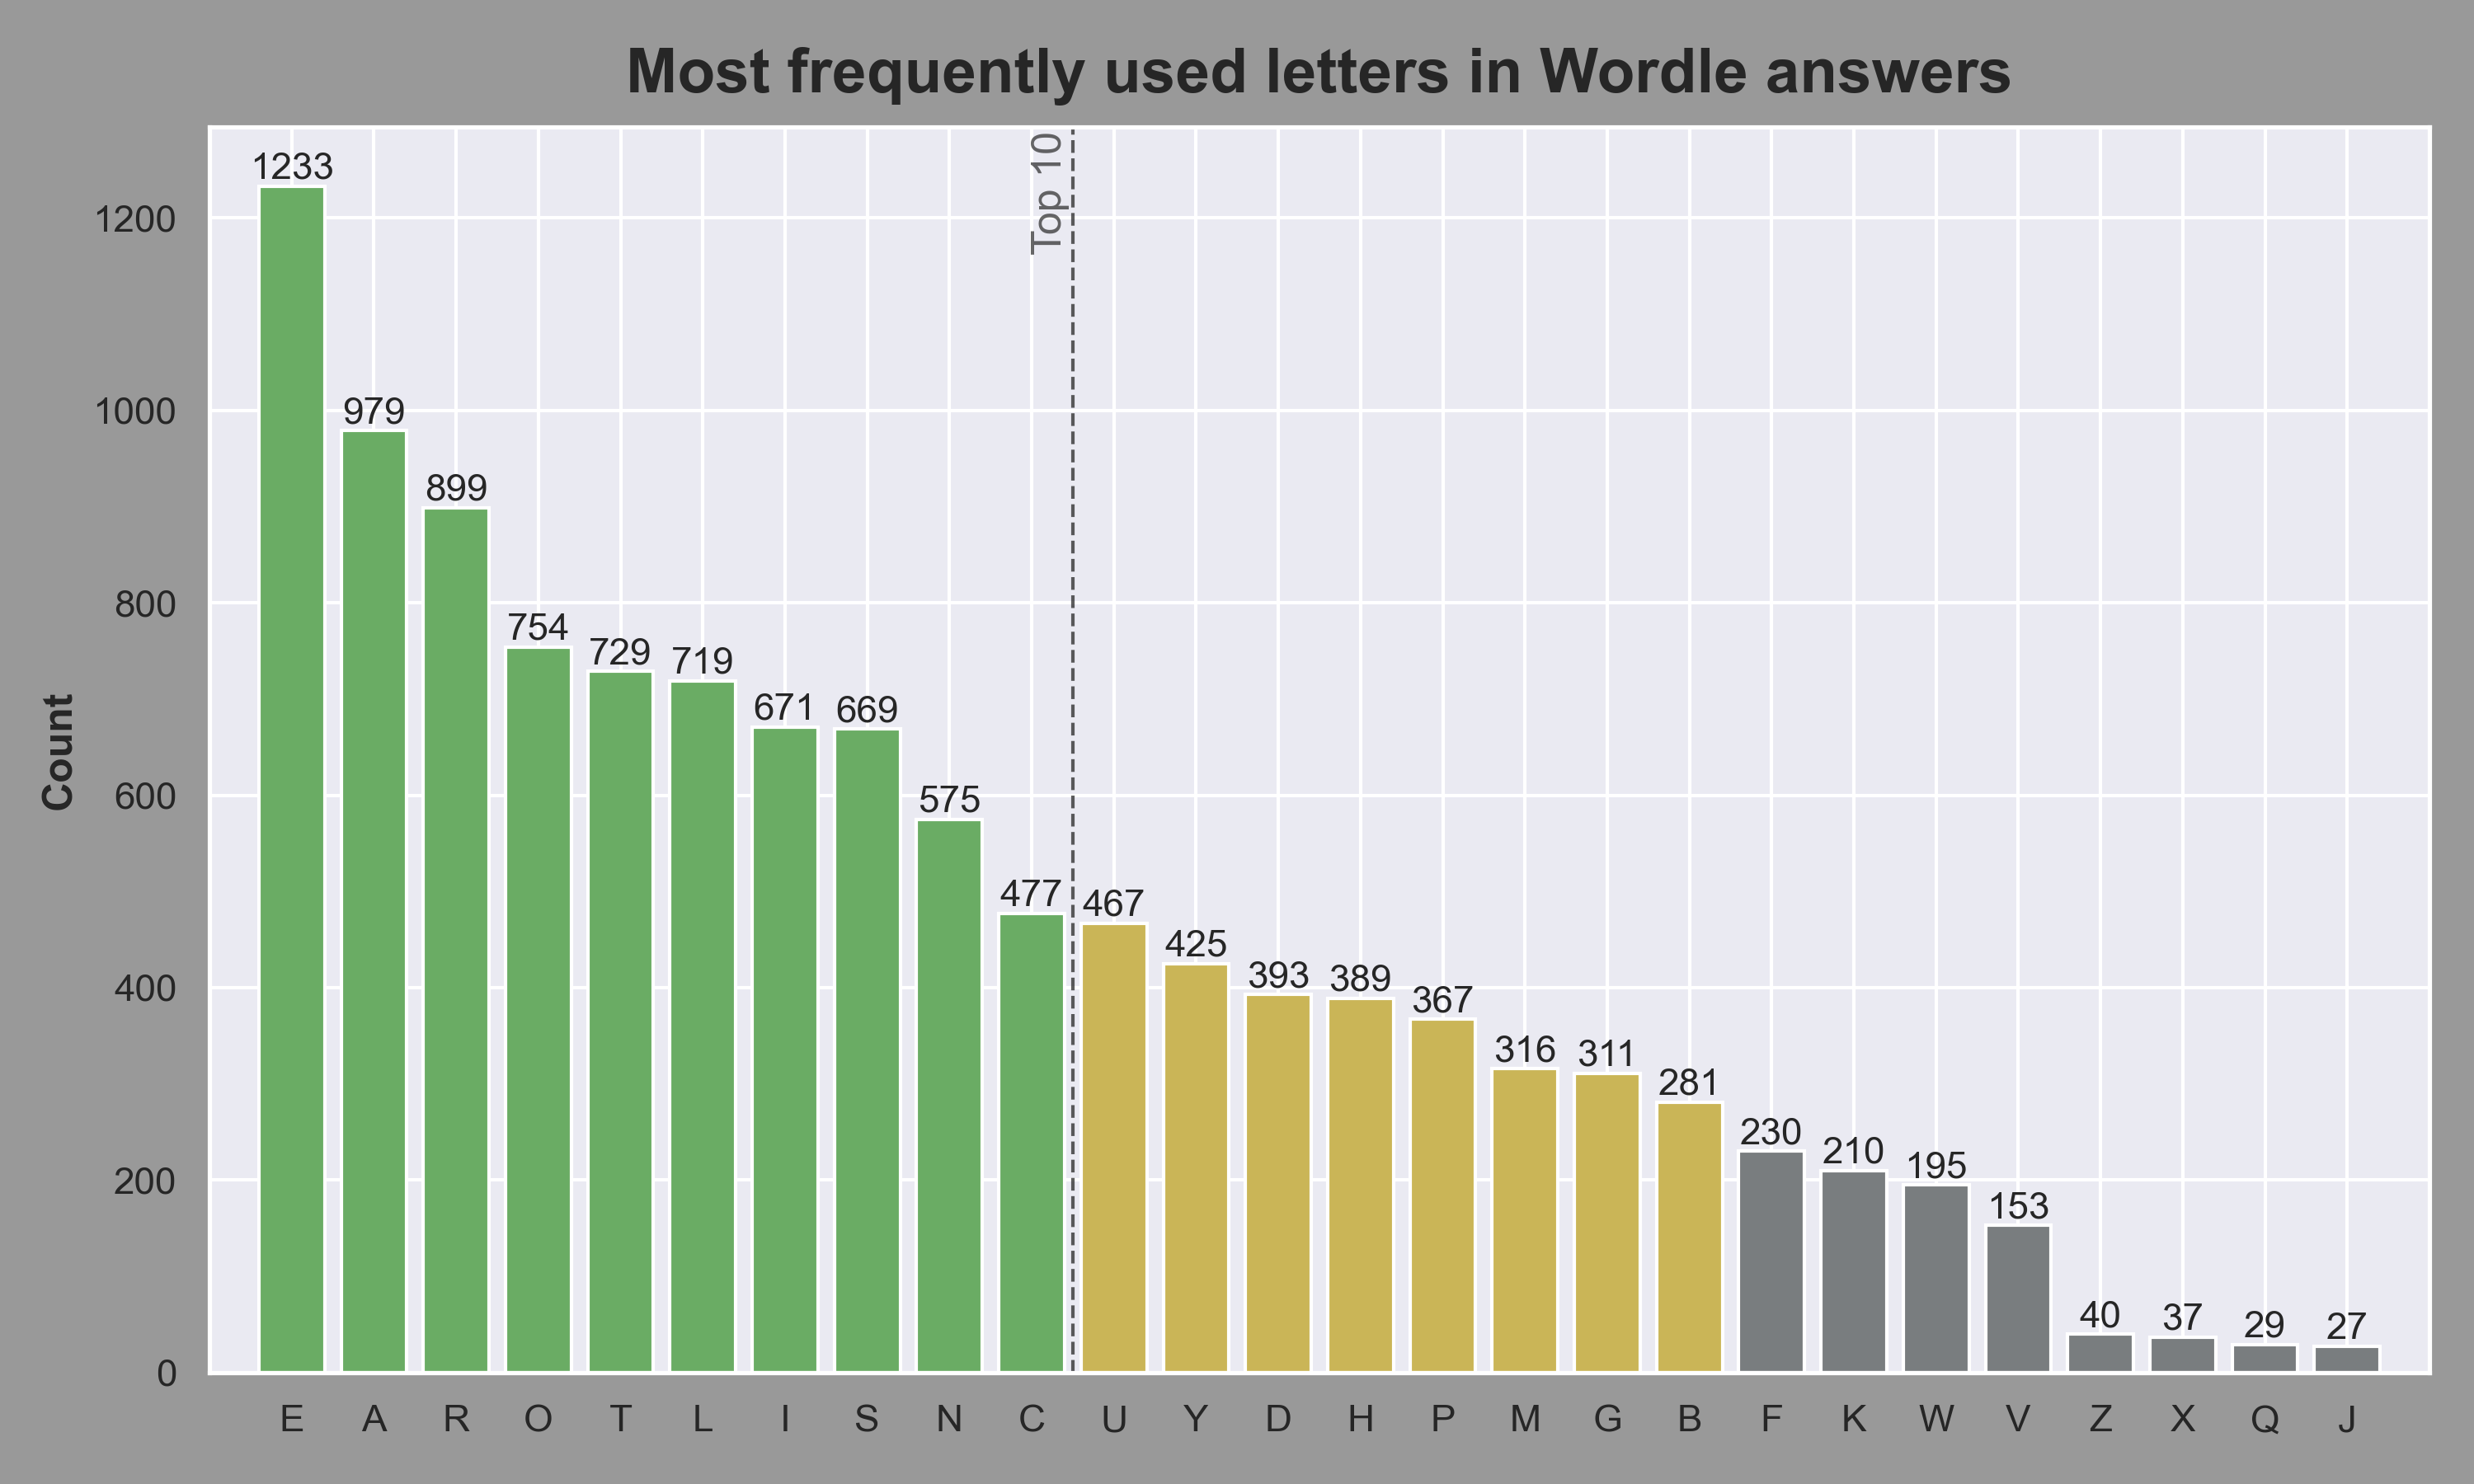!